## Python-gmt Test with FOCI Data from ERDDAP
### erddapy example for PMEL tools - Shiptracks

***erddapy requires python 3.6*** for passing time information (pandas datetime to timestamp doesn't appear to work in 2.7)
***gmt-python requires python 3.6***

### connecting and basic information

In [2]:
from erddapy import ERDDAP
import pandas as pd
import numpy as np

server_url='http://krafla.pmel.noaa.gov:8080/erddap'
e = ERDDAP(server=server_url)

Get only Shiptrack datafiles

In [3]:
df = pd.read_csv(e.get_search_url(response='csv', search_for='shiptrack'))

In [4]:
shiptracks = df['Dataset ID'].values
print(shiptracks)

['shiptrack_dy1704' 'shiptrack_dy1705' 'shiptrack_dy1706l1'
 'shiptrack_dy1706l2' 'shiptrack_dy1706l3' 'shiptrack_dy1708']


In [5]:
kw = {
    'standard_name': 'sea_water_temperature',
    'min_lon': -180.0,
    'max_lon': -130.0,
    'min_lat': 50.0,
    'max_lat': 90.0,
    'min_time': '2017-01-10T00:00:00Z',
    'max_time': '2018-01-10T00:00:00Z',
    'cdm_data_type': 'trajectory'
}

In [6]:
variables = [e.get_var_by_attr(dataset_id=ship, standard_name=lambda v: v is not None) for ship in shiptracks]

In [7]:
common_variables = set(variables[0]).intersection(*variables[1:])

common_variables 

{'latitude', 'longitude', 'time'}

In [8]:
constraints = {
    'longitude>=': kw['min_lon'],
    'longitude<=': kw['max_lon'],
    'latitude>=': kw['min_lat'],
    'latitude<=': kw['max_lat'],
    'time>=': kw['min_time'],
    'time<=': kw['max_time'],
}

download_url = e.get_download_url(
    dataset_id=shiptracks[0],
    protocol='tabledap',
    response='csv',
    variables=common_variables,
    constraints=constraints
)

print(download_url)

http://krafla.pmel.noaa.gov:8080/erddap/tabledap/shiptrack_dy1704.csv?time,latitude,longitude&longitude>=-180.0&longitude<=-130.0&latitude>=50.0&latitude<=90.0&time>=1484006400.0&time<=1515542400.0


In [9]:
from requests.exceptions import HTTPError

dfs = {}
for ship in shiptracks:
    print(ship)
    try:
        e = ERDDAP(server=server_url,
            dataset_id=ship,
            protocol='tabledap',
            response='csv',
            variables=common_variables,
            constraints=constraints
        )

        dfs.update({ship: e.to_pandas(
                            index_col='time',
                            parse_dates=True,
                            skiprows=(1,)  # units information can be dropped.
                            )})
    except HTTPError:
        print('Failed to generate url {}'.format(ship))
        continue


shiptrack_dy1704
shiptrack_dy1705
shiptrack_dy1706l1
shiptrack_dy1706l2
shiptrack_dy1706l3
shiptrack_dy1708


In [10]:
        
#add ocean starr for 2017 which is not a shiptrack but an underway system
try:
    e = ERDDAP(server=server_url,
        dataset_id='erddap_OS1701L1_underway',
        protocol='tabledap',
        response='csv',
        variables=common_variables,
        constraints=constraints
    )

    dfs.update({'erddap_OS1701L1_underway': e.to_pandas(
                        index_col='time',
                        parse_dates=True,
                        skiprows=(1,)  # units information can be dropped.
                        )})
except HTTPError:
    print('Failed to generate url {}'.format(ship))


In [11]:
#SCS GPX data is every second, downsample to hourly

dfh = {}
for ship, df in dfs.items():
    dfh.update({ship: df.resample('1H').mean()})

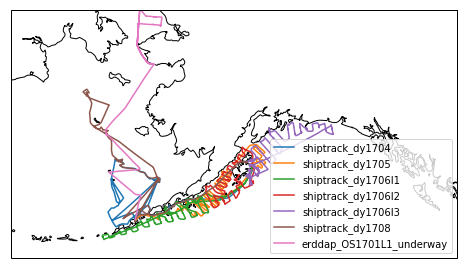

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter


def make_map(projection=ccrs.PlateCarree()):
    fig, ax = plt.subplots(figsize=(8, 8),
                           subplot_kw=dict(projection=projection))
    if projection == ccrs.PlateCarree():
        gl = ax.gridlines(draw_labels=True)
        gl.xlabels_top = gl.ylabels_right = False
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
    return fig, ax

projection=ccrs.LambertConformal(central_longitude=-160.0)
transformation=ccrs.PlateCarree()

land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='1.0')

dx = dy = 0.5
extent = -180, -130, kw['min_lat']+dy, kw['max_lat']+dy
extent = [-180, -130, 50, 66]
fig,ax = make_map(projection=projection)
for ship, df in dfh.items():
    ax.plot(df['longitude'], df['latitude'], label=ship, transform=transformation)

leg = ax.legend()

ax.add_feature(land_50m)
ax.coastlines(resolution='50m')
ax.set_extent(extent)

### Testing gmt-python as alternative plotting platform over cartopy or basemap

In [52]:
import gmt

In [86]:
fig = gmt.Figure()


fig.coast(region=[-180, -140, 50, 80], projection='B-160/60/55/60/6i', land='lightgray', water='gray',
          frame=True,U=True)

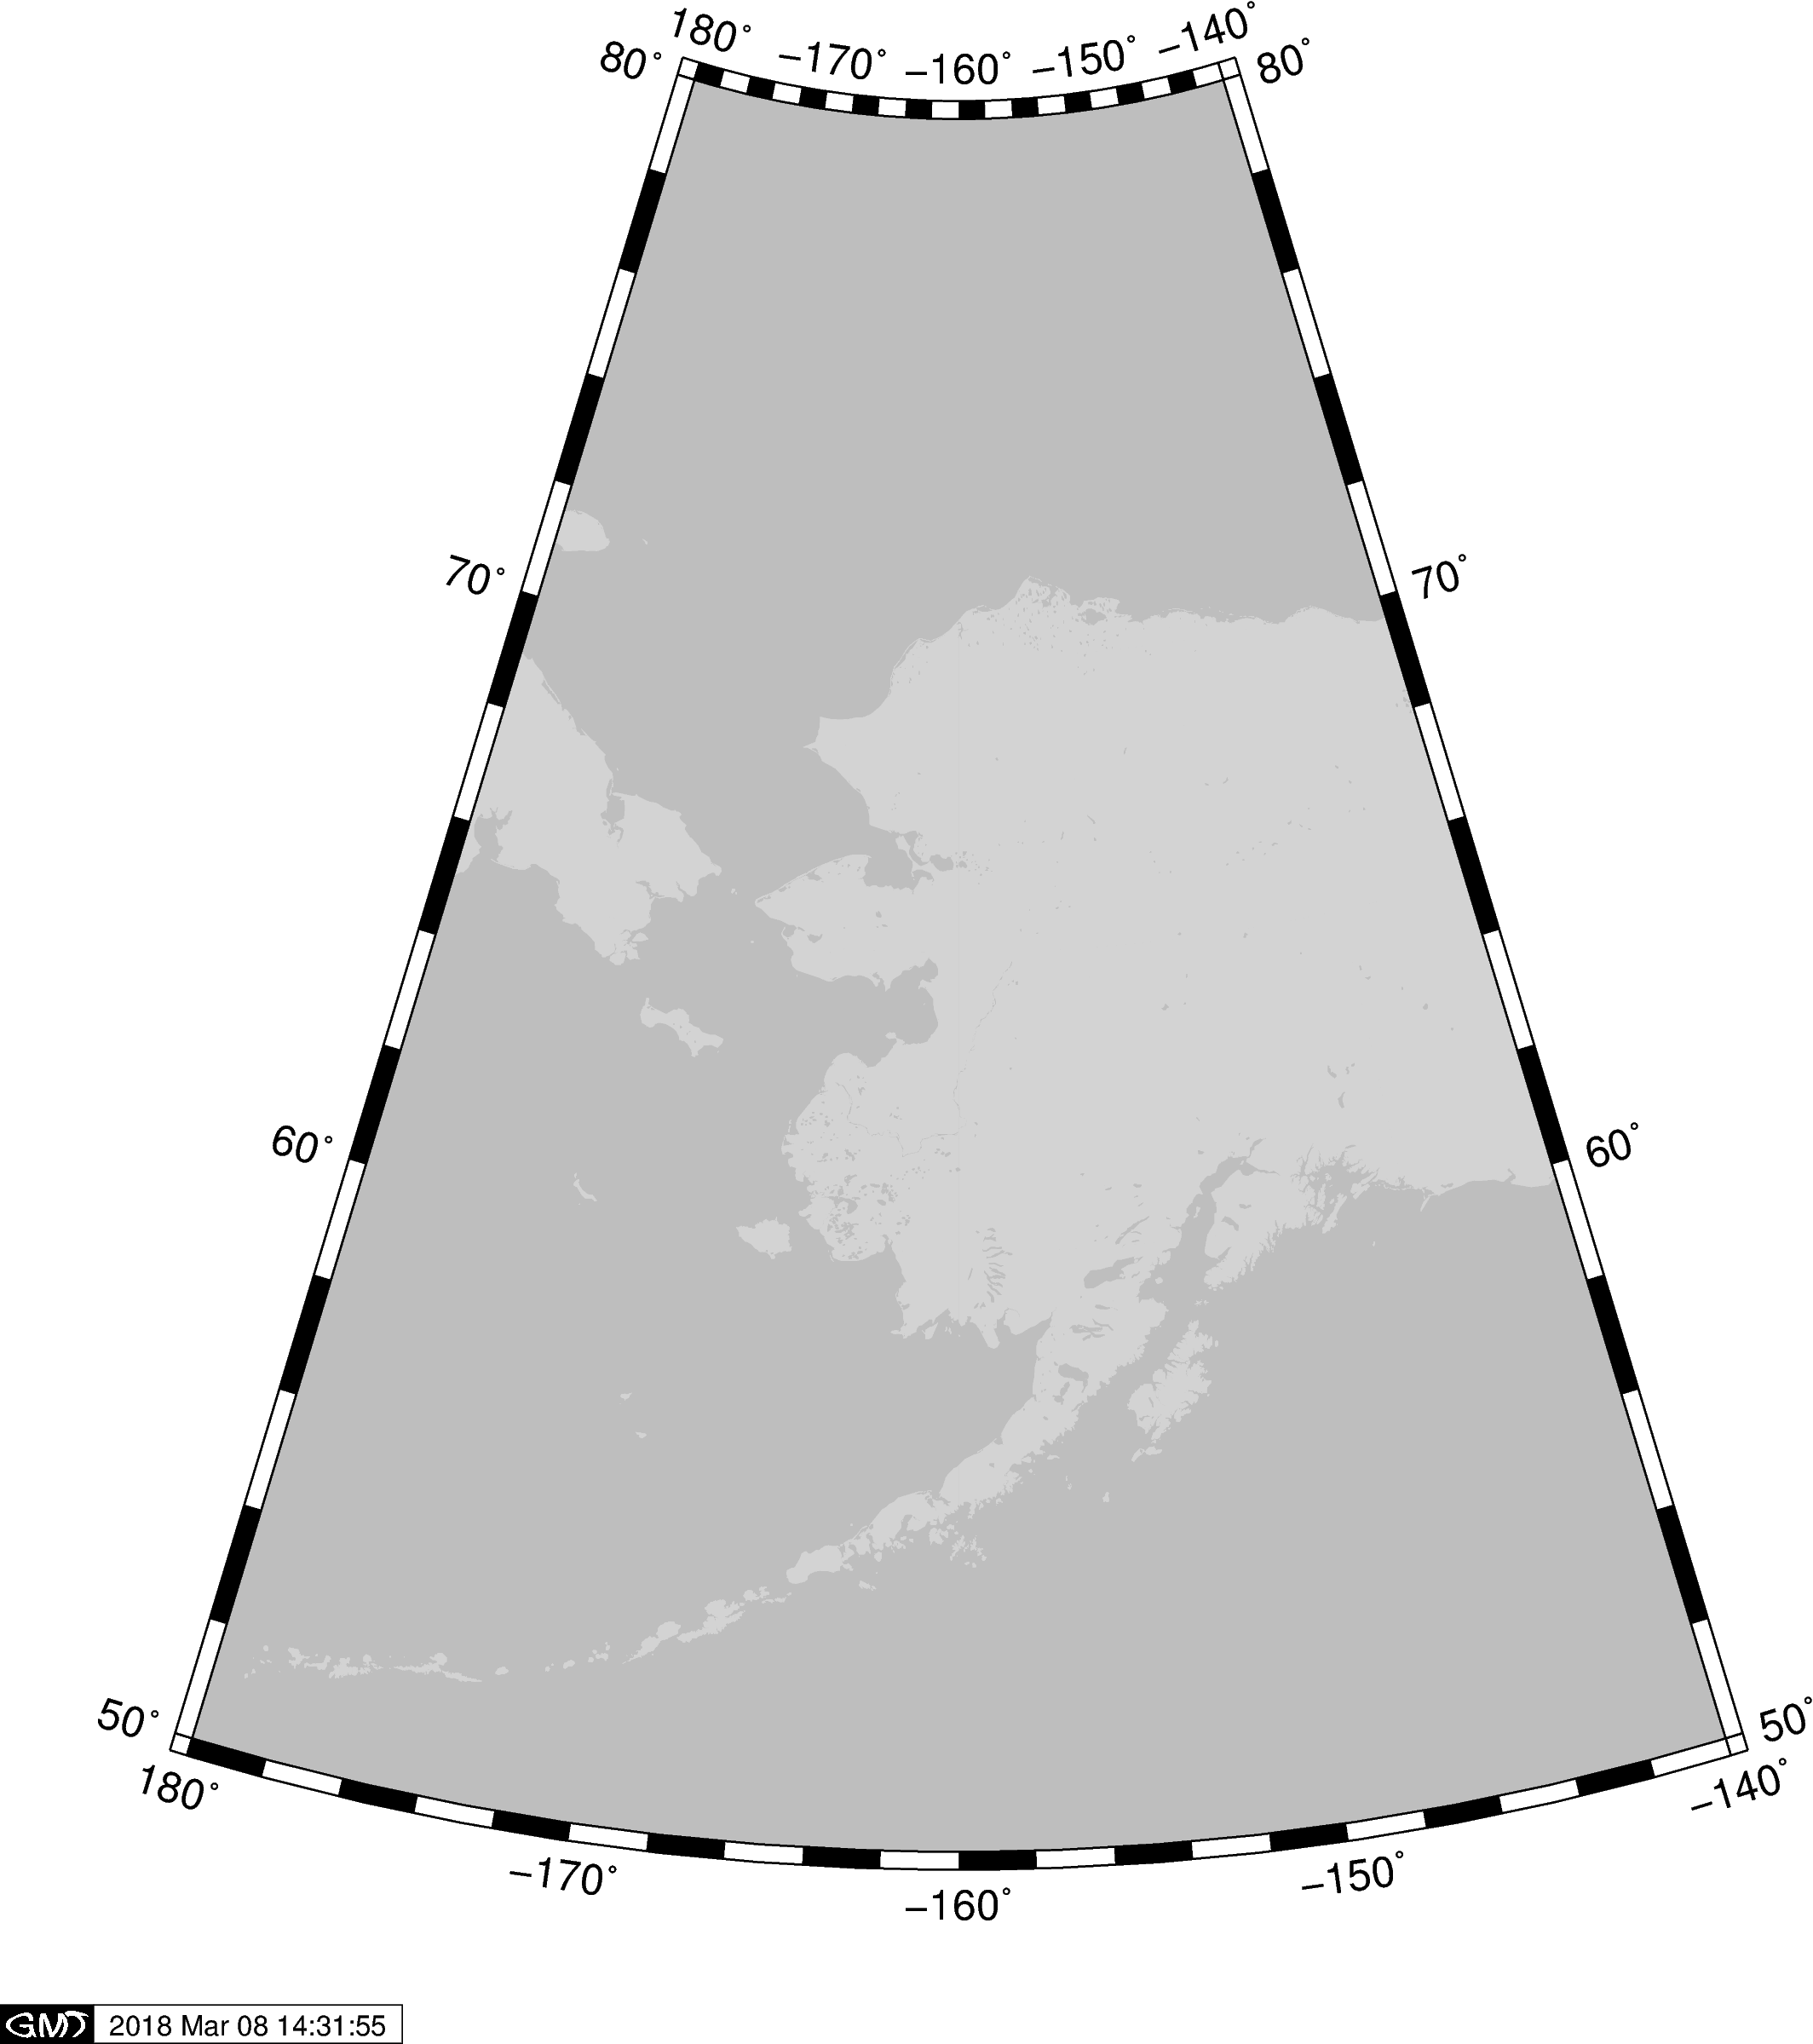

In [87]:
fig.show()

In [92]:
clist=['red','black','blue','green','cyan','yellow','orange']
count=0
for ship, df in dfh.items():
    fig.plot(x=df.longitude, y=df.latitude, color=clist[count], style='p0.1')
    print(clist[count])
    count+=1

red
black
blue
green
cyan
yellow
orange


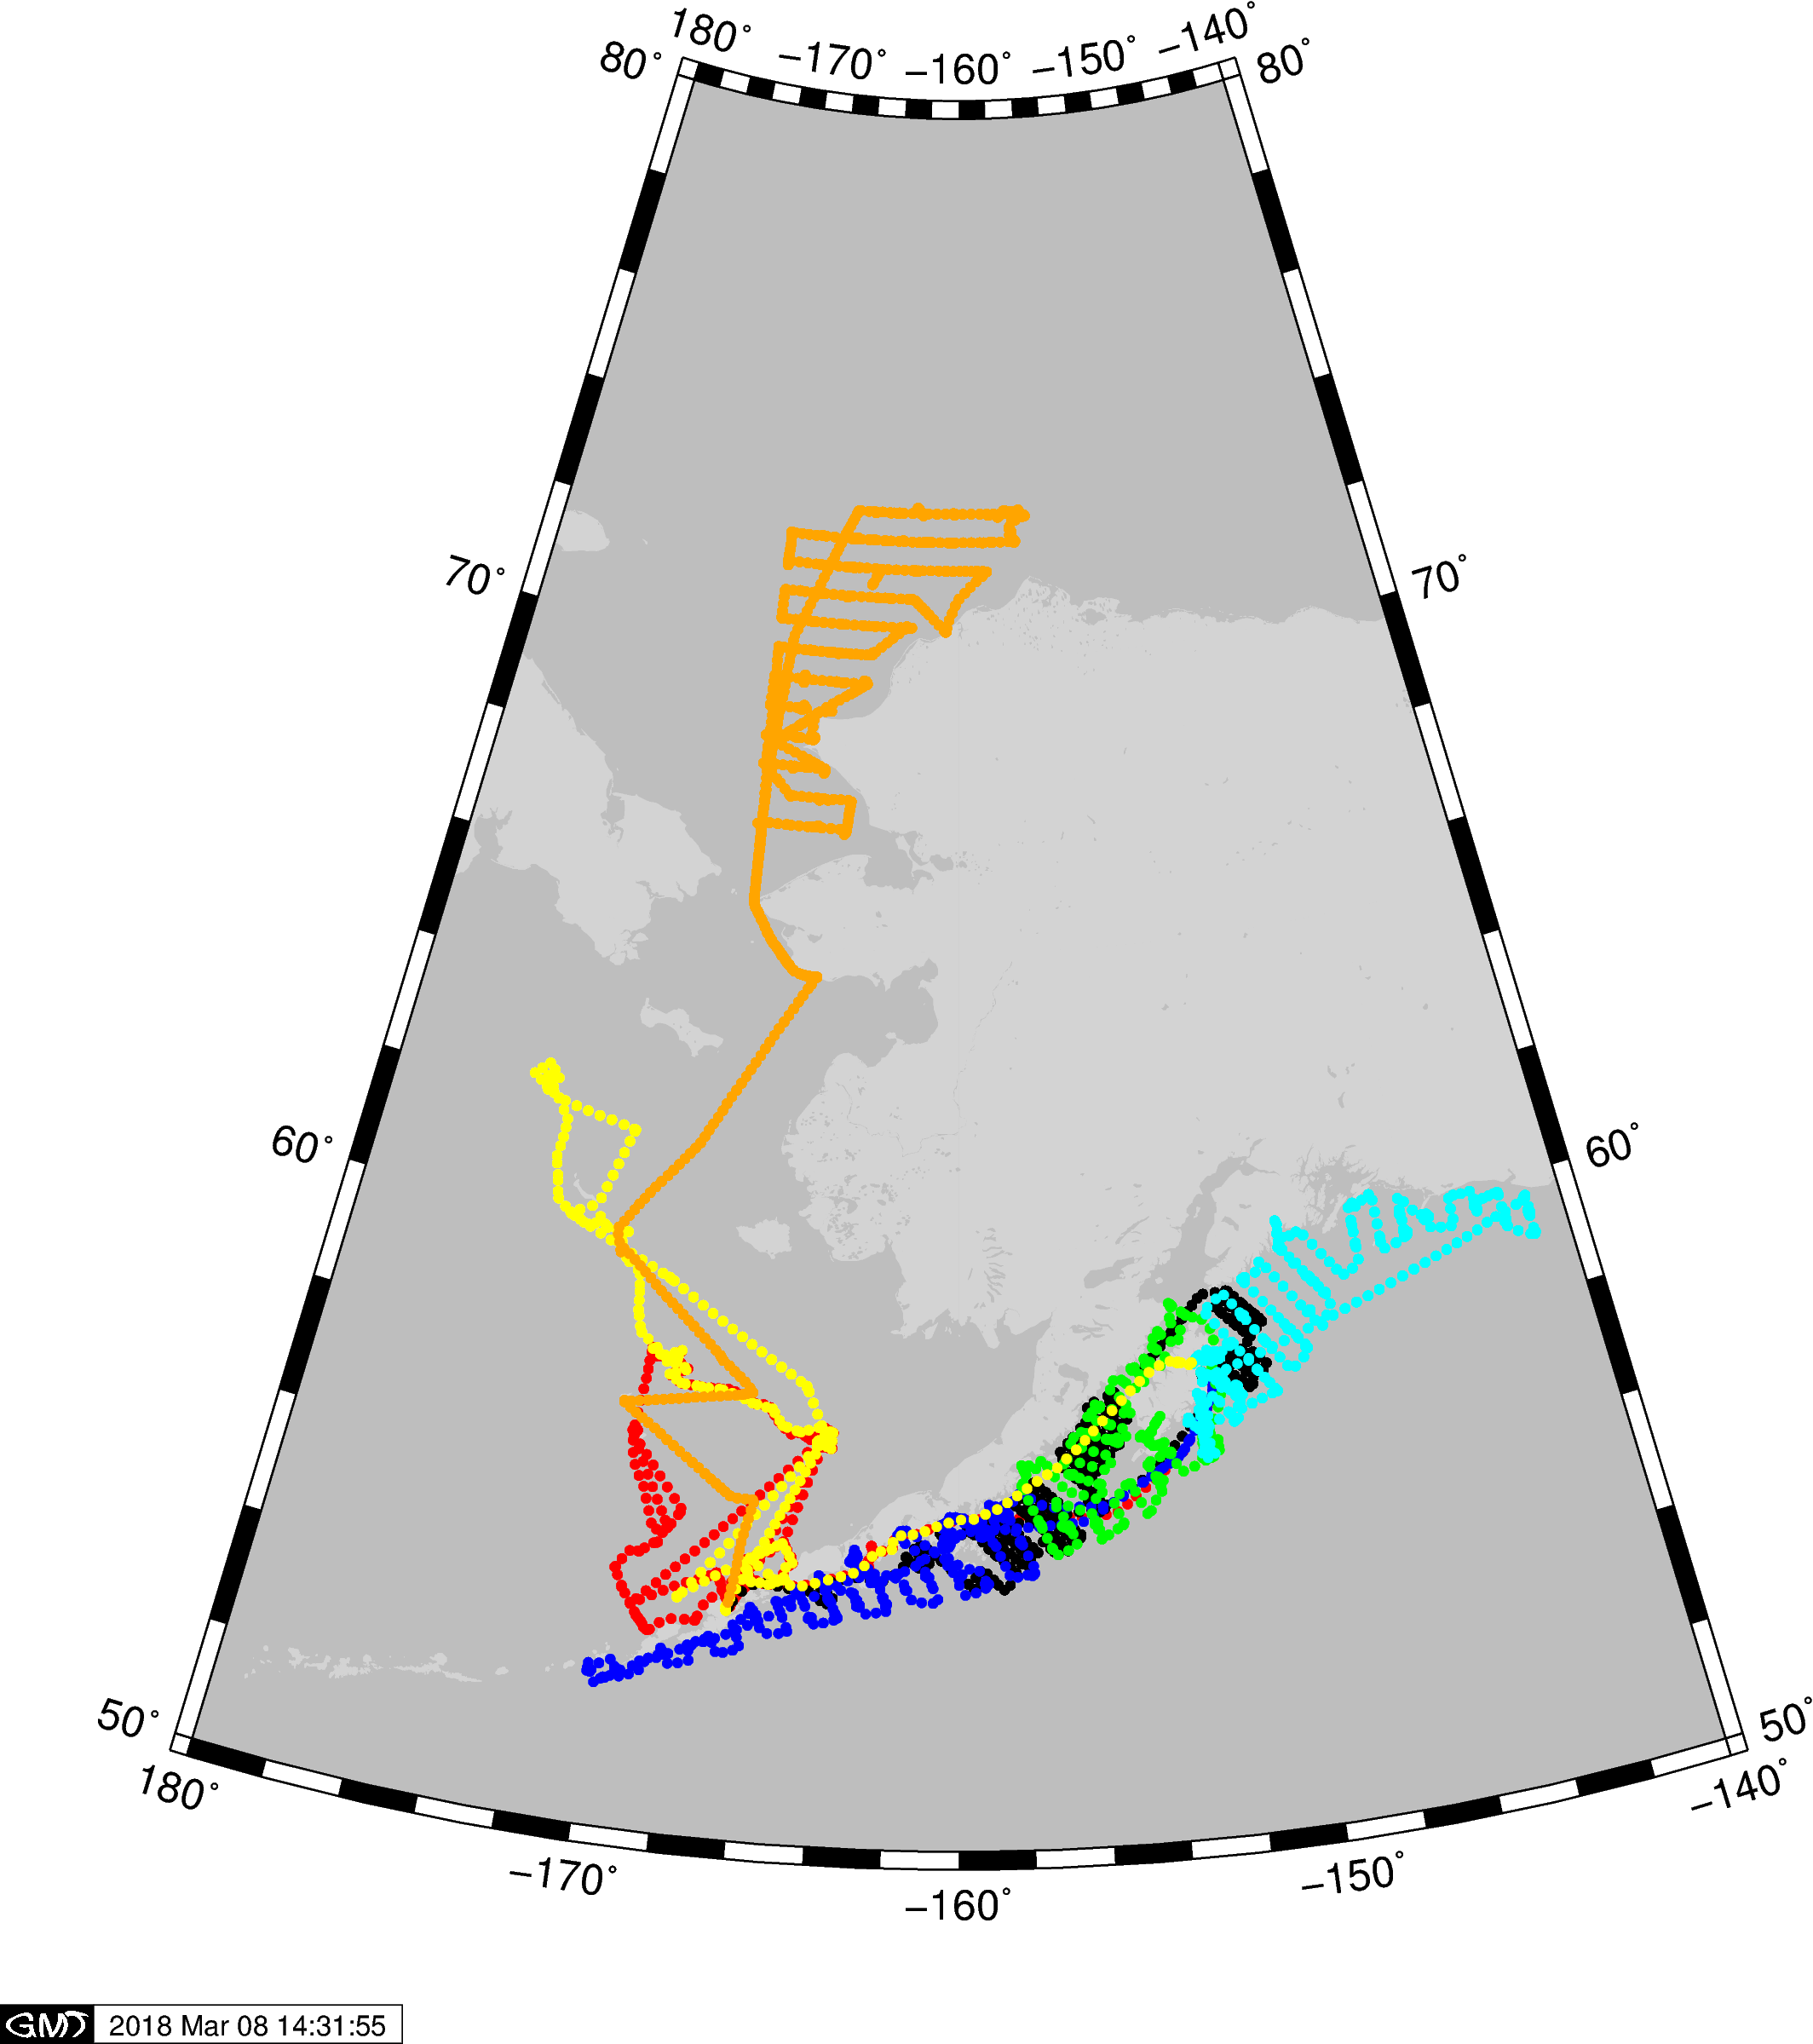

In [93]:
fig.show()